# Introduction

Les algorithmes de clustering sont des outils d'analyse des données qui permettent de grouper des échantillons, de sorte que les membres d'un même groupe (ou *cluster*) sont très similaires, alors que ceux de groupes différents ne le sont pas. Ces algorithmes ont des applications diverses et variées, en biologie (étude des espèces et analyse génétique), en médecine (reconnaissance d'image), en commerce (étude de marché et conception de produit) et en bien d'autres domaines.

Dans la suite, nous allons préciser explorer deux algorithmes de *clustering* : Kmeans et Clustering Spectral. Les deux seront implémentés et comparés sur des données différentes afin d'élucider leurs différences, ainsi que leurs points faibles et leurs points forts.

# Kmeans++

Kmeans est réputé comme l'algorithme de clustering le plus populaire. Il doit sa popularité à sa simplicité et à son efficacité, même si la précision du résultat n'est pas garantie.

Étant donné un entier k et un ensemble $X$ de n points de $\mathbb{R}^d$, le but est de choisir k centres $C = \{c_1,c_2...c_k\}$ qui minimisent la fonction : $$\phi(C) = \sum_{x\in X} \min_{c\in C} \|x_i,c\|^2$$

## Algorithme classique

L'algorithme Kmeans donne une solution simple et rapide de ce problème :

1. Choisir uniformément aribitrairement k centres $C = {c_1,c_2...,c_k}$ parmi $X$
2. Pour tout $i\in\{1..k\}$, construire $C_i$ l'ensemble des points de $X$ qui sont plus proches de $c_i$ que de n'importe quel autre centre
3. Mettre à jour $c_i := \dfrac{1}{|C_i|}\sum_{x\in C_i} x$
4. Répéter les étapes 2 et 3 jusqu'à convergence (i.e. $C$ ne change plus)

L'idée de l'algorithm repose sur le fait que les étapes 2 et 3 garantissent que $\phi$ diminue à chaque itération. Le choix initial de $C$ est par contre crucial et peut potentiellement aboutir sur un minimum local de $\phi$ au lieu d'approximer un minimum global.

On peut déjà voir que l'algorithme est adapté aux structures de données où les clusters se présentent comme des regroupements compacts et risque d'avoir des difficultés à distinguer des clusters qui sont imbriqués les uns dans les autres.

## Algorithme amélioré : Kmeans ++

L'algorithme Kmeans++ propose un choix plus intelligent des centres initiaux :

1.  a. Choisir le centre $c_1$ uniformément parmi $X$
    
    b. Ayant choisi $i$ centres $C_i = \{c_1,c_2...,c_i\}$, choisir le centre suivant parmi $x\in X$ avec probabilité $$\frac{\min_{c\in C_i} \|x,c\|^2}{\sum_{y\in X} \min_{c\in C_i} \|y,c\|^2}$$
    
    c. Répéter l'étape b jusqu'à obtenir $k$ centres $C_k$

2-4. Identiques à l'algorithme classique

L'algorithme suivant, nommé Kmeans++**[1]**, comporte une amélioration de la première étape qui permet d'obtenir des résultats plus consistants, tout en augmentant la vitesse de convergence en moyenne.

## Implémentation de Kmeans++

La fonction kmpp retourne les $k$ centres obtenus par la méthode Kmeans++ décrite plus haut. Elle prend en entrée l'ensemble $X$ des échantillons, le paramètre $k$ permet de choisir le nombre de clusters et iter le nombre maximal d'itération.

La fonction kmpp utilise la fonction auxiliaire d2seed qui se charge d'effectuer l'étape d'initialization, en choisissant les $k$ centres initiaux, tel que décrite par la méthode kmeans++.

Pour effectuer la selection aleatoire du centre suivant décrite dans l'étape 1.b, d2seed utilise la fonction auxiliaire random qui prend en entrée un vecteur de $w$ poids et retourne un indice sélectionnné avec probabilité  

In [ ]:
kmpp = function(X, k, iter=0)
d2seed = function(X, k)

## Auxiliary functions :

### $D^2$ random distribution :

The following algorithm returns a random index using a discrete (non negative) weight distribution w.

In [ ]:
random = function(w){
    n = length(w)
    # discrete cumulative distribution 
    p = cumsum(w)
    # simulate probability using Inverse Transform Sampling
    u = runif(1,0,p[n])
    # find the index of the inverse using dichotomic search
    a = 0
    b = n
    # loop invariant : a<b and p[a]<=u<p[b]
    while(b-a>1){
        c = a + (b-a)%/%2
        if (p[c]>u){
            b = c
        } else {
            a = c
        }
    }
    return(b)
}

### Euclidien distance

The following function computes the square of the euclidien distance between two vectors x and y.

In [ ]:
dist2 = function(x, y){
    return (t(x-y)%*%(x-y))
}

###  Cluster partitioning

* The following algorithm returns the indexing vector for the clusters obtained by partitioning the dataset *X* using a set of cluster centers *C*.

In [ ]:
iclusters = function(X, C){
    # sample size
    n = ncol(X)
    # cluster count
    k = ncol(C)
    # Cindex will contain the index of the nearest center
    Cindex = vector("double", n)
    # partitioning sample over cluster centers
    for (x in 1:n){
        d = dist2(X[,x],C[,1])
        Cindex[x] = 1
        for (c in 2:k){
            if (dist2(X[,x],C[,c]) < d){
                d = dist2(X[,x],C[,c])
                Cindex[x] = c
            }
        }
    }
    return(Cindex)
}

* The following algorithm returns the list of clusters obtained by partitioning the dataset *X* using the indexing vector *index*.

In [ ]:
clusters = function(X, index){
    # cluster count
    k = ncol(C)
    # constructing the list of clusters
    clist = vector("list", k)
    for (c in 1:k){
        cindex = Cindex==c
        clist[[c]] = X[,cindex]
    }
    return(clist)
}

## $D^2$ seeding method

The following algorithm returns a matrix of k randomly chosen initial centers from a dataset X, using the D² seeding method which works recursively as follows :

* Choose the first center $C_1$ uniformely at random from X

* Given the first $C = \{C_1,...C_{i-1}\}$ centers chosen, choose the next center $C_i$ at random from X using the probability distribution :
$\bigg(\dfrac{D(x)^2}{\sum_{x\in X} D(x)^2}\bigg)_{x\in X}$ where $D(x) = \min\big\{||x-c||:c\in C\big\}$ 

In [40]:
d2seed = function(X, k){
    # sample dimensions
    d = nrow(X)
    n = ncol(X)
    # allocate a dxk matrix for the centers
    C = matrix(NA_real_, d, k)
    # choose first center uniformely from the sample
    i = floor(runif(1,0,n))
    C[,1] = X[,i+1]
    # calculate initial weight distribution
    d2 = vector("double", n)
    for (i in 1:n){
        d2[i] = dist2(X[,i],C[,1])
    }
    # choose the next (k-1) remaining centers using the D² method
    for (c in 2:k){
        # select the next center using auxiliary function
        r = random(d2)
        C[,c] = X[,r]
        # update weight distribution
        for (i in 1:n){
            d2[i] = min(d2[i], dist2(X[,i],C[,c]))
        }
    }
    return(C)
}

## Kmeans++ algorithm

The following algorithm returns a matrix of k cluster centers for a dataset X, using the Kmeans algorithm initialized with the $D^2$ seeding method. The iter argument specifies the maximum number of iterations of the optimization loop.

In [41]:
kmpp = function(X, k, iter=0){
    # sample size
    n = ncol(X)
    # initialization of cluster centers
    C = d2seed(X,k)
    # optimization loop
    repeat{
        # Cindex will contain the index of the nearest scenter
        Cindex = vector("double",n)
        # partitioning sample over cluster centers
        for (x in 1:n){
            d = dist2(X[,x],C[,1])
            Cindex[x] = 1
            for (c in 2:k){
                if (dist2(X[,x],C[,c]) < d){
                    d = dist2(X[,x],C[,c])
                    Cindex[x] = c
                }
            }
        }
        # updating cluster centers
        convergence = TRUE
        for (c in 1:k){
            index = Cindex==c
            size = sum(index)
            cluster = X[,index]
            if (size>1){
                newcenter = rowSums(cluster)/size
            } else {
                newcenter = cluster
            }            
            if (all(newcenter!=C[,c])){
                convergence = FALSE
                C[,c] = newcenter
            }
        }
        iter = iter-1
        if(convergence || iter==0){
            break
        }
    }
    return(C)
}

# Clustering Spectral

## Définitions basiques

### Notation graphe

Soit $G = (V,E)$ un graphe non orienté avec $V = \{v_1, . . . ,v_2\}$ l'ensemble des sommets.
Dans la partie suivante, on suppose que le graphe $G$ est muni de poids, que chaque arête entre deux sommets $v_i$ et $v_j$ soit de poid non negative $w_{ij} ≥ 0$.
La matrice adjacente du graphe $G$ est la matrice $W = (w_{ij})$ $i,j=1,...,n$.

Le degrée d'un sommet $v_i \in V$ est defini par $d_i = \sum\limits_{j=1}^n w_{ij}$.

Le degrée matricielle $D$ est défini par une matrice diagonale ayant pour diagonales les degrées $d_1, . . . , d_n$.




### Graphe de similitude

Il y a plusieurs façon de transformer un ensemble donné de points $x_1, . . . , x_n$ doté d'une matrice de similarités $s_{ij}$ ou d'une matrice de distance $d_{ij}$ en un graphe. Lorsque l'on construit un graphe de similitude, le but est de modéliser la relation de voisin proche entre les points.

- Le ε-voisinage graphe : On connecte tous les points dont la distance l'un l'autre est plus petite que ε.

- Le k-plus proche voisin graphe : Ici le but est de connecter $v_i$ avec le sommet $v_j$ if $v_j$ est parmi les k-plus proches voisins de $v_i$ mais comme la relation de voisin n'est pas forcément symetrique, on considère deux différentes constructions.

    - Le k-plus proche voisin graphe : On ignore les directions des arêtes, on connecte $v_i$ et $v_j$ avec une arête non orientée si $v_i$ est parmi les k-plus proches voisins de $v_j$ ou si $v_j$ est parmi les k-plus proches voisins de $v_i$.
    - Le mutuel k-plus proche voisin graphe : On connecte les sommets $v_i$ et $v_j$ si on a $v_i$ est parmi les k-plus proches voisins de $v_j$ et si $v_j$ est parmi les k-plus proches voisins de $v_i$.

-Le graphe complet : Ici on connecte simplement l'ensemble des points avec une similaritée positive, le poids de chaque arête étant $s_{ij}$.

### Graphe Laplaciens et leurs propriétés basiques

Dans la partie suivante on suppose toujours que $G$ est non orienté, pondéré de la matrice $W$ avec $w_ij = w_ji ≥ 0$.

La matrice du graphe Laplacien non normalisé est défini par $L = D − W$.

## Fonctions auxiliaires

### Graphes de similitudes

* La fonction suivante retourne un ε-voisinage graphe, étant données une matrice de distance *d* et un seuil *e*.

In [42]:
egraph = function(d,e){
    n=nrow(d)
    for(i in 1:n){
        for(j in i:n){
            if(d[i,j]>e){
                d[i,j]=0
                d[j,i]=0
            } else {
                d[i,j]=1
                d[j,i]=1
            }
        }
    }
    return(d)
}

* La fonction suivante retourne un k-plus proche voisin graphe, étant données une matrice de distance *d* et un nombre de voisins *k*.

In [43]:
knearest = function(k,d,mutual=FALSE){
    n=nrow(d)
    #Matrix n*p of zero
    M=matrix(data=numeric(n*n),ncol=n,nrow=n)
    for(i in 1:n){
        #Iterate the number of point that we have to connect
        kk=k
        while(kk>0){
            #Cordinates of the nearest point of i
            #Start at (i,1)
            ii=i
            if(i==1){ jj=2 }
            else{ jj=1 }
            if(mutual){
                min2=d[jj,ii] 
                min=d[ii,jj] 
            }
            else{
                min=d[ii,jj]
            }
            #Found the cordinates of the nearest point of i
            for(j in 1:n){
                if(j!=i){
                    if(mutual){
                        if((d[i,j]<min && M[i,j]==0 && d[j,i]<min2 && M[j,i]==0){
                            min=d[i,j]
                            min2=d[j,i]
                            ii=i
                            jj=j
                        }
                    }
                    else{
                        if((d[i,j]<min && M[i,j]==0)){
                            min=min(d[i,j],d[j,i])
                            ii=i
                            jj=j
                        }

                    }
                }
            }
            kk=kk-1
            #M take the nearest point which is at (ii,jj)
            if(mutual){
                
            }
            else{
                M[ii,jj]=d[ii,jj]
            }
        }
    }
    return(M)
}

### Matrice des degrées

* La fonction suivante calcule la matrice des degrées pour une matrice de similitude *W*.

In [44]:
degree = function(W){
    n=nrow(W)
    #Allocate a zero matrix length n*n
    D = matrix(data=numeric(n*n), nrow=n, ncol=n)
    for(i in 1:n){
        D[i,i]=sum(W[i,])
    }
    return(D)
}

### Matrice Laplacien

La fonction suivante calcul la matrice Laplacien d'une matrice de similitude *W*. L'argument *normalize* spécifie la méthode de normalisation utilisée pour la matrice Laplacien. Par défaut cela est mis à 0 (non normalisé).

In [45]:
laplacian = function(W,normalize=0){
    #length of the matrix W
    n=ncol(W)
    #degree matrix
    D=degree(W)
    L=D-W
    #Normalized Laplacian Lsym
    if(normalize==1){
        RD=solve(D^(1/2))
        return(RD*L*RD)
    }
    #Normalized Laplacian Lrw
    if(normalize==2){
        return(solve(D)*L)
    }
    #Unormalized Laplacian of W
    return(L)
}

### k premiers vecteurs propres

La fonction suivante retourne les *k* premiers vecteurs propres (dans l'ordre de leur valeur propres correspondantes) pour donnée une matrice *L*.

In [46]:
eigenvectors = function(L,k){
    #Compute all the eigenvalues and eigenvectors of L
    X=eigen(L)
    #Take the first k eigenvectors
    t=length(X$values)
    return(X$vectors[,(t-k+1):t])
}

## Algorithme de Clustering Spectral

L'idée cachée derière l'algorithme de Clustering Spectral est de translaté les données dans l'espace vectoriel $\mathbb{R}^k$ en utilisant les graphes Laplaciens. Ce changement de perspective, qui dans certains cas est du au propriétés des graphes Laplaciens, améliore les resultats du clustering obtenue à travers le clustering de k-means

La fonction suivante implémente les algorithmes de Clustering Spectral. Elle retourne un *k*-cluster indexant les vecteurs pour une matrice de similitude *S*. L'argument *normalize* peut-être utilisé pour spécifier une méthode de normalisation de Laplacien (1 for $L_{rw}$ and 2 for $L_{sym}$).

In [47]:
spec = function(S,k,normalize=0){
    # Weighted adjacency matrix of S
    W=S
    # Compute the normalized Laplacian Lrw
    L=laplacian(W,normalize)
    # Compute the first k-eigenvectors of Lrw
    U=eigenvectors(L,k)
    # Normalize the rows
    if(normalize==2){
        n = nrow(U)
        N=(rowSums(U^2)^(1/2))
        for(i in 1:n){
            if (N[i]>0){
                for(j in 1:k){
                    U[i,j]=U[i,j]/N[i]
                }
            }
        }
    }
    # Transpose the matrix U
    Y=t(U)
    # Cluster the points with k-means algorithm
    C=kmpp(Y,k)
    return(iclusters(Y,C))
}

# Application Numérique

## Visualisation

The following function performs a multidimentional plot of *k* clusters obtained from a dataset *X* using the indexing vector *index*.
* The *names* vector contains the labels for data coordinates
* The *title* string specifies the title of the image
* The *col* vector specifies cluster colors
* The *shape* value specifies the shape of the dots

In [109]:
pclusters = function(X, k, index, names, title, col = NULL, shape=1){
    # dataset dimension
    d = nrow(X)
    # computing boundaries for the data
    blist = vector("list",d)
    for(i in 1:d){
        blist[[i]] = c(min(X[i,]),max(X[i,]))
    }
    # constructing the list of clusters
    clist = vector("list", k)
    for (c in 1:k){
        bool = index==c
        clist[[c]] = X[,bool]
    }
    # plotting colors
    if (length(col)==0){
        col = c(2:(k+1))
    }
    # adjusting margins
    par(oma=c(2,2,5,2), mar=(c(0,0,0,0)+.5))
    # plotting in R²
    if (d==2){
        plot(clist[[1]][1,],clist[[1]][2,], col = col[1],
             pch=shape, xlab=names[1], ylab=names[2], 
             xlim = blist[[1]], ylim = blist[[2]])
        for (c in 2:k){
            points(clist[[c]][1,],clist[[c]][2,], col = col[c],
                   xlab=names[1], ylab=names[2], pch=shape)
        }
        title(title, outer=TRUE)
    }
    # plotting in higher dimensions
    else {
        par(mfrow=c(d,d))
        for (i in 1:d){
            for (j in 1:d){
                # plotting dimension name
                if (j==i){
                    plot(blist[[i]], blist[[i]], #ann = F,  
                         type = 'n', xaxt = 'n', yaxt = 'n',)
                    text(x = mean(blist[[i]]), y = mean(blist[[i]]),
                         paste(names[i]), cex = 1.25, col = "black")
                } else {
                    # plotting the clusters in [j,i] space
                    if(length(nrow(clist[[1]]))>0){
                        plot(clist[[1]][j,],clist[[1]][i,], ann=F,
                             col = col[1], xaxt='n', yaxt='n', 
                             pch=shape, xlim = blist[[j]], 
                             ylim = blist[[i]])
                        for (c in 2:k){
                            if(length(nrow(clist[[c]]))>0){
                                points(clist[[c]][j,],clist[[c]][i,], 
                                       ann=F, pch=shape, col = col[c],
                                       xaxt='n', yaxt='n')
                            }
                        }
                    } else {
                        plot(clist[[2]][j,],clist[[2]][i,], ann=F,
                         col = col[1], xaxt='n', yaxt='n', pch=shape, 
                         xlim = blist[[j]], ylim = blist[[i]])
                        for (c in 3:k){
                            if(length(nrow(clist[[c]]))>0){
                                points(clist[[c]][j,],clist[[c]][i,],
                                       ann=F, pch=shape, col = col[c],
                                       xaxt='n', yaxt='n')
                            }
                        }
                    }
                    
                    # drawing axes
                    if (i==d){
                        axis(1)
                    } else if (i==1){
                        axis(3)
                    }
                    if (j==d){
                        axis(4)
                    } else if (j==1){
                        axis(2)
                    }
                }
            }
        }
        title(title, outer=TRUE)
    }
}

## Simulated dataset

The following is a two-dimentional simulated clustering dataset.

In [220]:
# install.packages("mlbench")
library(mlbench)
set.seed(111)
obj = mlbench.spirals(100,1,0.025)
X =  t(4 * obj$x)

* Clustering result using Kmeans++ :

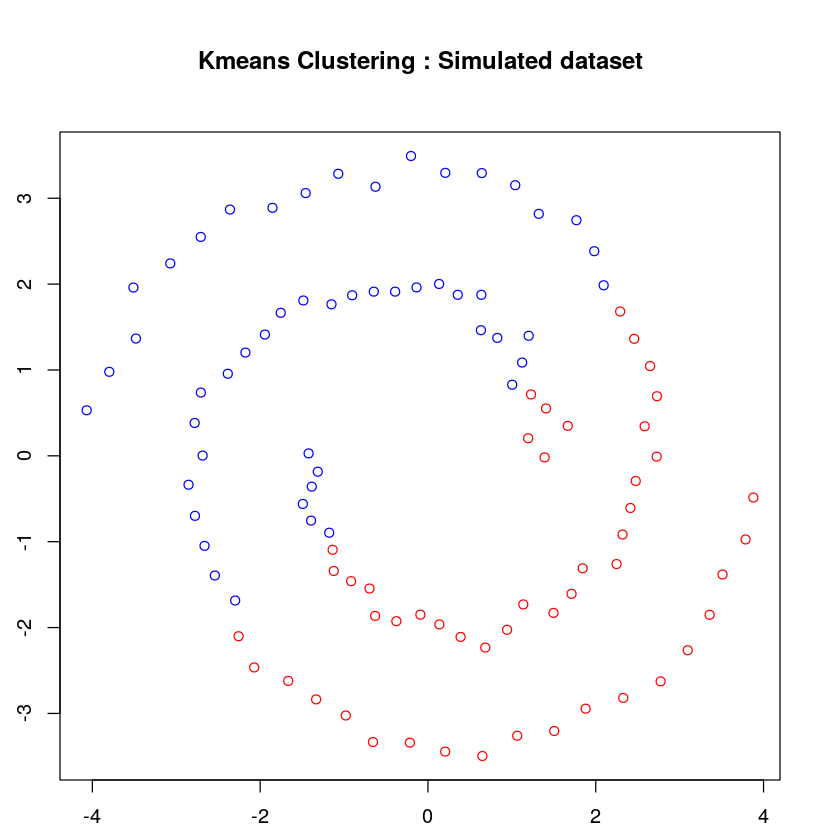

In [250]:
# clustering
kmcluster = iclusters(X,kmpp(X,2))
# plotting
pclusters(X,2,kmcluster,c("X1","X2"), col=c(2,4),
          "Kmeans Clustering : Simulated dataset")

* Clustering using Spectral Clustering :

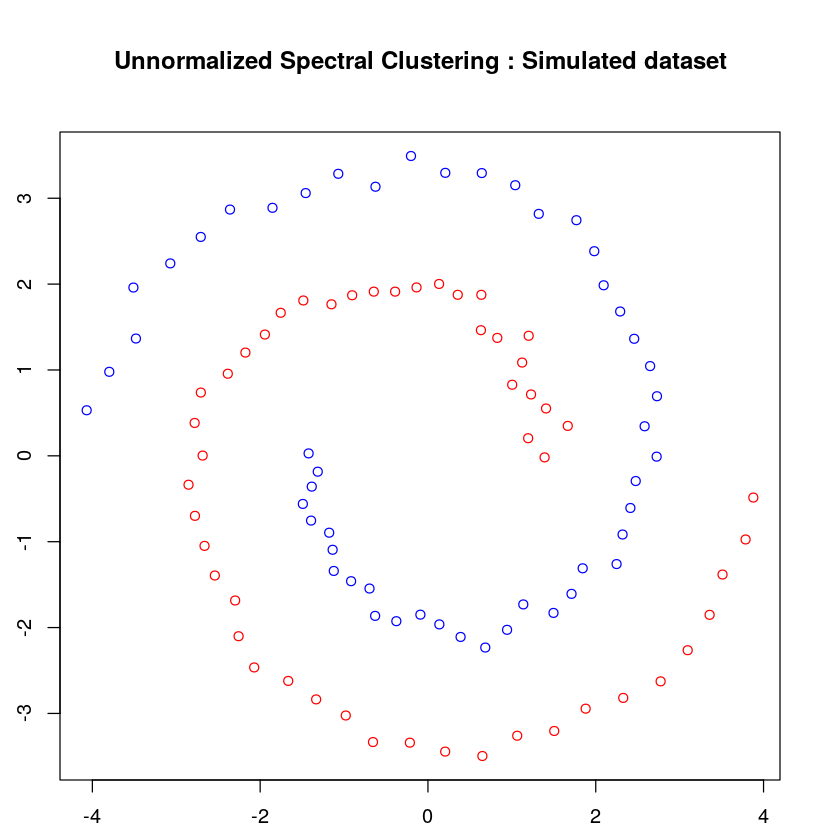

In [265]:
# distance matrix
D = matrix(0,n,n)
for (i in 1:n){
    for (j in 1:n){
        D[i,j] = exp(-8*dist2(X[,i],X[,j]))
    }
}
# ε-neighborhood graph
e = .5
S = egraph(D,e)
# clustering
spcluster = spec(D,2,0)
# plotting
pclusters(X,2,spcluster,c("X1","X2"), col=c(2,4),
          "Unnormalized Spectral Clustering : Simulated dataset")

The spectral clustering algorithm clearly outperforms kmeans++ in this simulated example.

## Iris Flower dataset

In this second numerical application, we use Fisher's Iris Flower Dataset. It consists of three classes of Iris flowers : 
    - Iris Setosa
    - Iris Versicolour
    - Iris Virginica

Each class contains 50 instances with the following measurements :
    1. sepal length in cm
    2. sepal width in cm
    3. petal length in cm
    4. petal width in cm 


In [52]:
d = read.csv(file="iris.data",head=F,sep=",")
d$V5<-factor(d$V5)
summary(d)

       V1              V2              V3              V4       
 Min.   :4.300   Min.   :2.000   Min.   :1.000   Min.   :0.100  
 1st Qu.:5.100   1st Qu.:2.800   1st Qu.:1.600   1st Qu.:0.300  
 Median :5.800   Median :3.000   Median :4.350   Median :1.300  
 Mean   :5.843   Mean   :3.054   Mean   :3.759   Mean   :1.199  
 3rd Qu.:6.400   3rd Qu.:3.300   3rd Qu.:5.100   3rd Qu.:1.800  
 Max.   :7.900   Max.   :4.400   Max.   :6.900   Max.   :2.500  
               V5    
 Iris-setosa    :50  
 Iris-versicolor:50  
 Iris-virginica :50  
                     
                     
                     

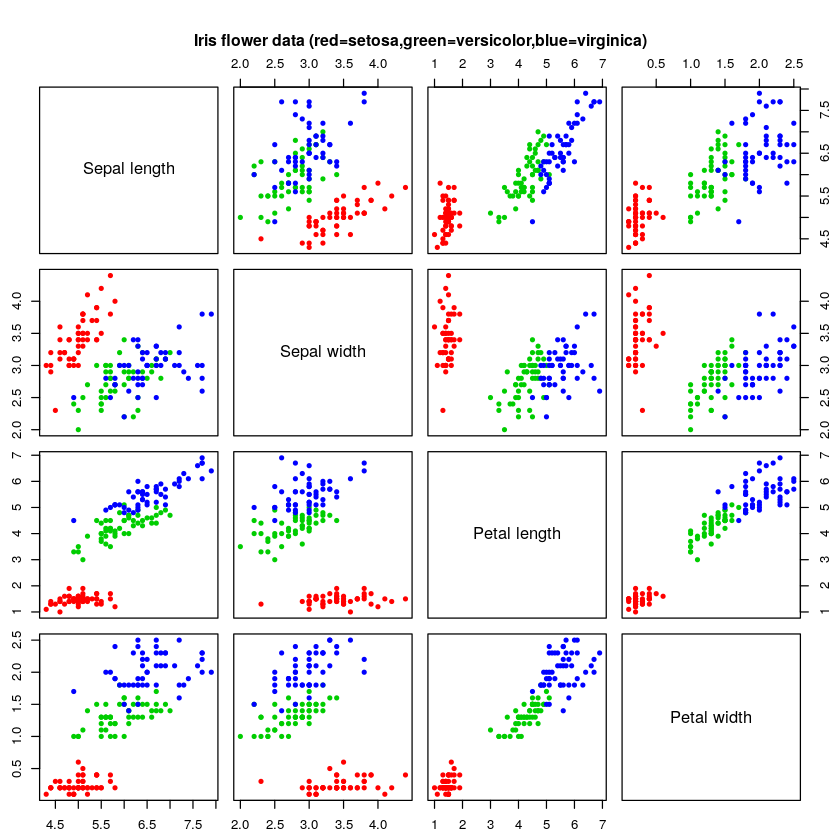

In [53]:
n = 150
X = t(matrix(c(d$V1,d$V2,d$V3,d$V4),nrow=n,ncol=4))
index = as.numeric(d$V5)
t = "Iris flower data (red=setosa,green=versicolor,blue=virginica)"
pclusters(X,3,index,c("Sepal length","Sepal width",
                      "Petal length","Petal width"),
          t ,shape=20)

* Clustering using Kmeans

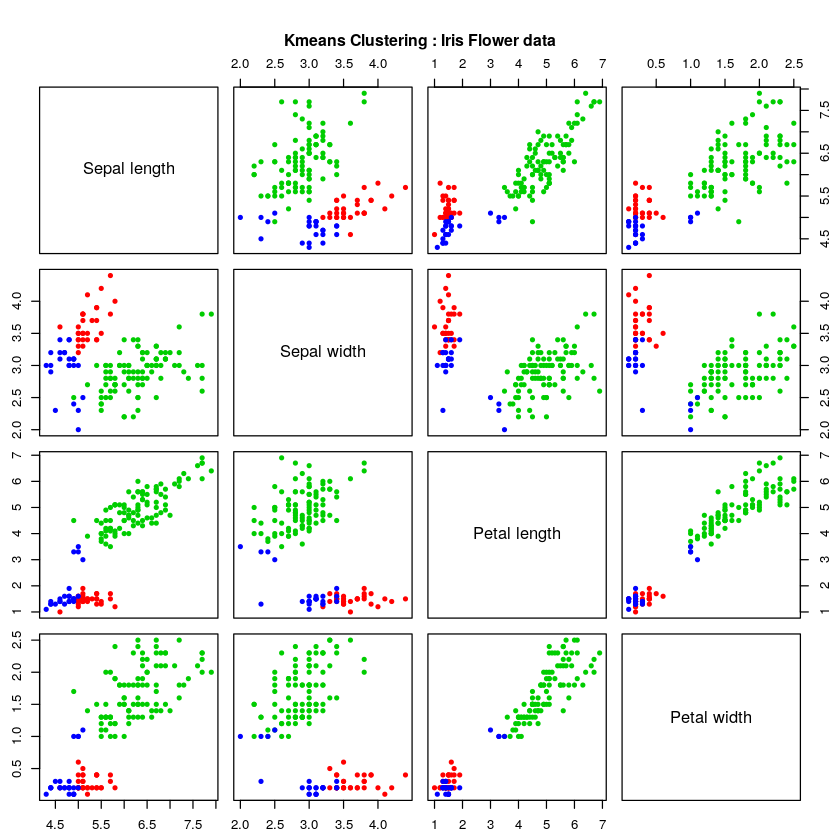

In [54]:
# clustering
kmcluster = iclusters(X,kmpp(X,3))
# plotting
pclusters(X,3,kmcluster,c("Sepal length","Sepal width",
                          "Petal length","Petal width"),
          "Kmeans Clustering : Iris Flower data", shape=20)

* Clustering using Spectral Clustering :

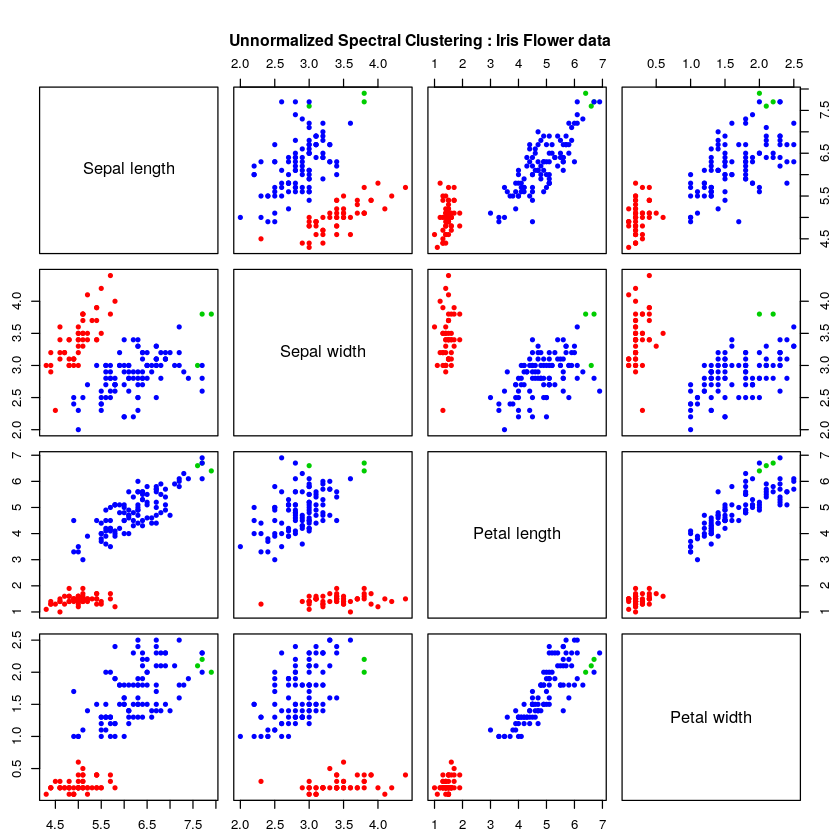

In [55]:
# distance matrix
D = matrix(0,n,n)
for (i in 1:n){
    for (j in 1:n){
        D[i,j] = dist2(X[,i],X[,j])
    }
}
# ε-neighborhood graph
e = 1
S = egraph(D,e)
# clustering
spcluster = spec(S,3,0)
# plotting
pclusters(X,3,spcluster,c("Sepal length","Sepal width",
                          "Petal length","Petal width"), 
          "Unnormalized Spectral Clustering : Iris Flower data",
          shape=20)

# Preliminary conclusions

So far, we can see that Kmeans++ outperforms Spectral Clustering on the Iris Flower dataset. Further study of the behavior of spectral clustering is needed to better understand its sensitivity to certain parameters.

# References

**[1]** Arthur D, Vassilvitskii S (2007) k-means++: the advantages of careful seeding. Proceedings of the Eighteenth Annual ACM-SIAM Symposium on Discrete Algorithms. pp 1027--1035.

**[2]** von Luxburg, U., A Tutorial on Spectral Clustering, in *Statistics and Computing*, 17 (4), 2007.


**[3]** Fisher,R.A. "The use of multiple measurements in taxonomic problems" Annual Eugenics, 7, Part II, 179-188 (1936); also in "Contributions to Mathematical Statistics" (John Wiley, NY, 1950).

**[4]** L. Zelnik-Manor and P.  Perona. Self-tuning spectral clustering. In L. K. Saul, Y.  Weiss, and L. Bottou, editors, Advances in Neural Information Processing  Systems 17 , pages 1601–1608. MIT  Press, Cambridge, MA,2005.